In [1]:
data_samples <- read.csv("data_melatonion.csv", check.names = TRUE)
#data_samples <- read.csv("filter_samples_Day1_2.csv", check.names = TRUE)
#data_zotus<-read.csv("data_zotus/Final_ZOTUs_results3.csv", check.names = FALSE)
data_zotus<-read.csv("Final_ZOTUs_results_Aug_24.csv", check.names = FALSE)
#data_samples
data_clock_ctool<-read.csv("Melatonin-Clock-Stool.csv", check.names = FALSE)


In [2]:
# Perform the merge to add Clock_stool from df_B to df_A
data_samples <- merge(data_samples, data_clock_ctool[, c("Cohort", "Sample_id", "Timepoint", "Day", "Clock_stool")],
                   by = c("Cohort", "Sample_id", "Timepoint", "Day"),
                   all.x = TRUE)  # Keep all rows from df_A, even if no match in df_B


In [3]:
# Convert time string to numeric hours
data_samples$Clock_stool_numeric <- sapply(strsplit(data_samples$Clock_stool, ":"), function(x) {
  as.numeric(x[1]) + as.numeric(x[2]) / 60
})



In [4]:
Study_variable <- 'Melatonin_pg_g_Stool'  # 'Time_since_last_stool' , 'Clock_stool' , 'Time_since_last_meal', 'Time_since_last_sleep'
as.symbol(Study_variable)
Age <- '6 months'     #'all' , '3 months', '6 months';, '12 months'



Melatonin_pg_g_Stool

In [5]:
library(dplyr)
#data_samples<-data_samples[,c('Cohort', 'Sample_Code_16s',  'Timepoint', 'Clock_stool',	'Time_since_last_stool',	'Time_since_last_meal',	'Time_since_last_sleep')]
data_samples<-data_samples[,c('Cohort', 'Sample_Code_16s',  'Timepoint', 'Clock_stool_numeric', Study_variable)]



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [6]:
# Function to extract age group based on conditions
 
extract_age_group <- function(sample_id) {

      # Check if the sample ID is NA
  if (is.na(sample_id)) {
    return(NA)
  }

    
  # Check if the sample ID starts with 'S'
  if (startsWith(sample_id, 'S')) {
    # Split the sample ID by '-'
    parts <- strsplit(sample_id, "-")[[1]]
    # Get the second division
    division <- parts[2]
    # Extract the first two characters
    return(as.integer(substr(division, 1, 2)))
  }
    
  # Split the sample ID by '-'
  parts <- strsplit(sample_id, "-")[[1]]
  # Get the second division
  division <- parts[2]
  # Extract the last character
  last_char <- substring(division, nchar(division), nchar(division))
  # Check if the sample ID starts with 'I'
  if (startsWith(sample_id, 'I')) {
    # If so, multiply the last character by 3
    return(as.integer(last_char) * 3)
    #return(0)       # Sleepy cohort ages between 5 and 31 months, so, will be excluded
  } else {
    # Otherwise, return the last character as integer
    return(as.integer(last_char))
  }
}

# Apply the function to create the age group column
data_samples$age_group <- sapply(data_samples$Sample_Code_16s, extract_age_group)

# View the updated data
#print(data)


dim(data_samples)
data_samples[1:3,]

[1] 1115    6

Cohort Sample_Code_16s Timepoint Clock_stool_numeric Melatonin_pg_g_Stool
1 COLIC  C03-03          t1        NA                                      
2 COLIC  C04-03          t1        NA                                      
3 COLIC  C05-03          t1        NA                                      
  age_group
1 3        
2 3        
3 3

In [7]:
data_samples <- data_samples[data_samples$Melatonin_pg_g_Stool!='nan',]
data_samples <- data_samples[data_samples$Melatonin_pg_g_Stool!='',]

# Z-score Normalization
data_samples <- data_samples %>%
  mutate(Melatonin_pg_g_Stool_scaled = (as.numeric(Melatonin_pg_g_Stool) - mean(as.numeric(Melatonin_pg_g_Stool), na.rm = TRUE)) / 
          sd(as.numeric(Melatonin_pg_g_Stool), na.rm = TRUE))

data_samples <- data_samples %>%
  mutate(Melatonin_pg_g_Stool = as.numeric(Melatonin_pg_g_Stool))


data_samples <- data_samples[data_samples$Melatonin_pg_g_Stool < 1000 & data_samples$Melatonin_pg_g_Stool > 100, ]



Warning message:
"There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `Melatonin_pg_g_Stool_scaled = `/`(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings."
Warning message:
"There was 1 warning in `mutate()`.
ℹ In argument: `Melatonin_pg_g_Stool = as.numeric(Melatonin_pg_g_Stool)`.
Caused by warning:
! NAs introduced by coercion"


In [8]:

data_samples_clean <- na.omit(data_samples)


In [9]:

# Merge df1 with the filtered df2
merged_data <- merge(data_samples_clean, data_zotus, by = "Sample_Code_16s", all.x = FALSE)

dim(merged_data)

# Get the dimensions of merged_data
data_size <- dim(merged_data)


[1] 396  17

In [10]:
merged_data_age <- merged_data[merged_data$Cohort != 'SLEEPY', ]  # exclude sleepy cohort from age comparison
#merged_data_age <- merged_data
if (Age == '3 months'){
    merged_data_age <- merged_data_age[merged_data_age$age_group ==3,]}

if (Age == '6 months'){
    merged_data_age <- merged_data_age[merged_data_age$age_group ==6,]}

if (Age == '12 months'){
    merged_data_age <- merged_data_age[merged_data_age$age_group ==12,]}



In [11]:
# Run linear regressions
model_abundance <- lm(Abundance_all ~ Melatonin_pg_g_Stool, data = merged_data_age)
model_shannon <- lm(Shannon_Diversity ~ Melatonin_pg_g_Stool + Clock_stool_numeric, data = merged_data_age)
model_richness <- lm(Richness ~ Melatonin_pg_g_Stool + Clock_stool_numeric, data = merged_data_age)
model_evenness <- lm(Evenness ~ Melatonin_pg_g_Stool, data = merged_data_age)
model_rel_abun <- lm(Rel_Abun_0.1 ~ Melatonin_pg_g_Stool, data = merged_data_age)

# Extract p-values
p_abundance <- summary(model_abundance)$coefficients[2, 4]
p_shannon <- summary(model_shannon)$coefficients[2, 4]
p_richness <- summary(model_richness)$coefficients[2, 4]
p_evenness <- summary(model_evenness)$coefficients[2, 4]
p_rel_abun <- summary(model_rel_abun)$coefficients[2, 4]

# Display p-values
p_values <- data.frame(
  Variable = c("Abundance_all", "Shannon_Diversity", "Richness", "Evenness", "Rel_Abun_0.1"),
  P_Value = c(p_abundance, p_shannon, p_richness, p_evenness, p_rel_abun)
)

print(p_values)


           Variable    P_Value
1     Abundance_all 0.19207812
2 Shannon_Diversity 0.45599161
3          Richness 0.02166305
4          Evenness 0.66274774
5      Rel_Abun_0.1 0.16678501


In [12]:
# Load necessary libraries
library(dplyr)

# Convert Melatonin_pg_g_Stool to numeric if it's a character or factor
merged_data_age <- merged_data_age %>%
  mutate(Melatonin_pg_g_Stool = as.numeric(Melatonin_pg_g_Stool))

# Group Melatonin_pg_g_Stool into tens, summarise, and add the count as a new column
merged_data_age_grouped <- merged_data_age %>%
  mutate(Melatonin_Group = cut(
    Melatonin_pg_g_Stool, 
    breaks = seq(0, max(Melatonin_pg_g_Stool, na.rm = TRUE), by = 5),
    include.lowest = TRUE, 
    labels = seq(5, max(Melatonin_pg_g_Stool, na.rm = TRUE), by = 5)  # Use upper bounds only (10, 20, etc.)
  )) %>%
  group_by(Melatonin_Group) %>%
  summarise(
    Abundance_all_mean = mean(Abundance_all, na.rm = TRUE),
    Shannon_Diversity_mean = mean(Shannon_Diversity, na.rm = TRUE),
    Richness_mean = mean(Richness, na.rm = TRUE),
    Evenness_mean = mean(Evenness, na.rm = TRUE),
    Rel_Abun_0.1_mean = mean(Rel_Abun_0.1, na.rm = TRUE),
    Melatonin_pg_g_Stool_scaled_mean = mean(Melatonin_pg_g_Stool_scaled, na.rm = TRUE),
      Melatonin_pg_g_Stool_mean = mean(Melatonin_pg_g_Stool, na.rm = TRUE),
    Count = n()  # Add the count of samples in each group
  )

# View the grouped data
print(merged_data_age_grouped)


# A tibble: 56 × 9
   Melatonin_Group Abundance_all_mean Shannon_Diversity_mean Richness_mean
   <fct>                        <dbl>                  <dbl>         <dbl>
 1 105                        117385.                   1.70          269.
 2 110                        134572                    1.20          270 
 3 115                        141235                    2.35          318.
 4 120                        179635                    1.81          282 
 5 125                        140409                    2.11          307 
 6 130                        120572                    2.28          308.
 7 135                        154651.                   2.38          401.
 8 140                        216185.                   2.45          419.
 9 145                        138247.                   2.53          408.
10 150                        149531                    2.28          385.
# ℹ 46 more rows
# ℹ 5 more variables: Evenness_mean <dbl>, Rel_Abun_0.1_mean <db

In [13]:
# Load necessary libraries
library(dplyr)

# Convert Melatonin_pg_g_Stool to numeric if it's a character or factor
merged_data_age <- merged_data_age %>%
  mutate(Melatonin_pg_g_Stool = as.numeric(Melatonin_pg_g_Stool))

# Group Melatonin_pg_g_Stool into tens, summarise, and add the count as a new column
merged_data_age_grouped <- merged_data_age %>%
  mutate(Melatonin_Group = cut(
    Melatonin_pg_g_Stool, 
    breaks = seq(0, max(Melatonin_pg_g_Stool, na.rm = TRUE), by = 5),
    include.lowest = TRUE, 
    labels = seq(5, max(Melatonin_pg_g_Stool, na.rm = TRUE), by = 5)  # Use upper bounds only (5, 10, 15, etc.)
  )) %>%
  group_by(Melatonin_Group) %>%
  summarise(
    Abundance_all_mean = mean(Abundance_all, na.rm = TRUE),
    Shannon_Diversity_mean = mean(Shannon_Diversity, na.rm = TRUE),
    Richness_mean = mean(Richness, na.rm = TRUE),
    Evenness_mean = mean(Evenness, na.rm = TRUE),
    Rel_Abun_0.1_mean = mean(Rel_Abun_0.1, na.rm = TRUE),
    Melatonin_pg_g_Stool_scaled_mean = mean(Melatonin_pg_g_Stool_scaled, na.rm = TRUE),
    Melatonin_pg_g_Stool_mean = mean(Melatonin_pg_g_Stool, na.rm = TRUE),

    Clock_stool_numeric_mean = mean(Clock_stool_numeric, na.rm = TRUE), # Add mean Clock_stool_numeric
    Clock_stool_numeric_median = median(Clock_stool_numeric, na.rm = TRUE), # Add median Clock_stool_numeric
    Count = n()  # Add the count of samples in each group
  )

# View the grouped data
print(merged_data_age_grouped)


# A tibble: 56 × 11
   Melatonin_Group Abundance_all_mean Shannon_Diversity_mean Richness_mean
   <fct>                        <dbl>                  <dbl>         <dbl>
 1 105                        117385.                   1.70          269.
 2 110                        134572                    1.20          270 
 3 115                        141235                    2.35          318.
 4 120                        179635                    1.81          282 
 5 125                        140409                    2.11          307 
 6 130                        120572                    2.28          308.
 7 135                        154651.                   2.38          401.
 8 140                        216185.                   2.45          419.
 9 145                        138247.                   2.53          408.
10 150                        149531                    2.28          385.
# ℹ 46 more rows
# ℹ 7 more variables: Evenness_mean <dbl>, Rel_Abun_0.1_mean <d

In [14]:
# Filter the data where Count is greater than 1
filtered_data <- merged_data_age_grouped %>%
  filter(Count > 0)

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`

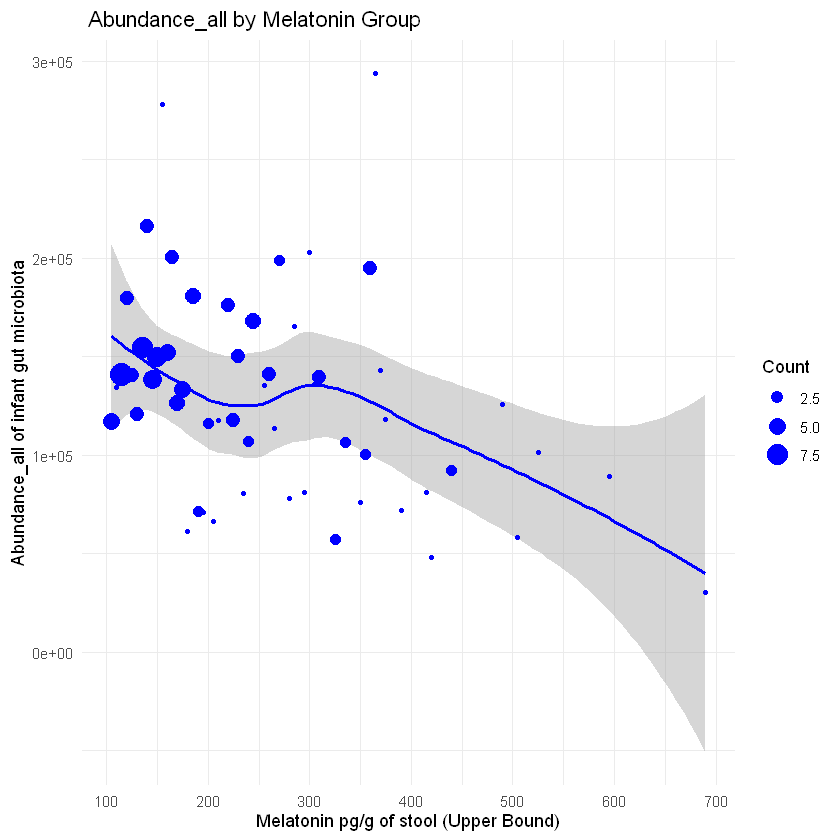

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."


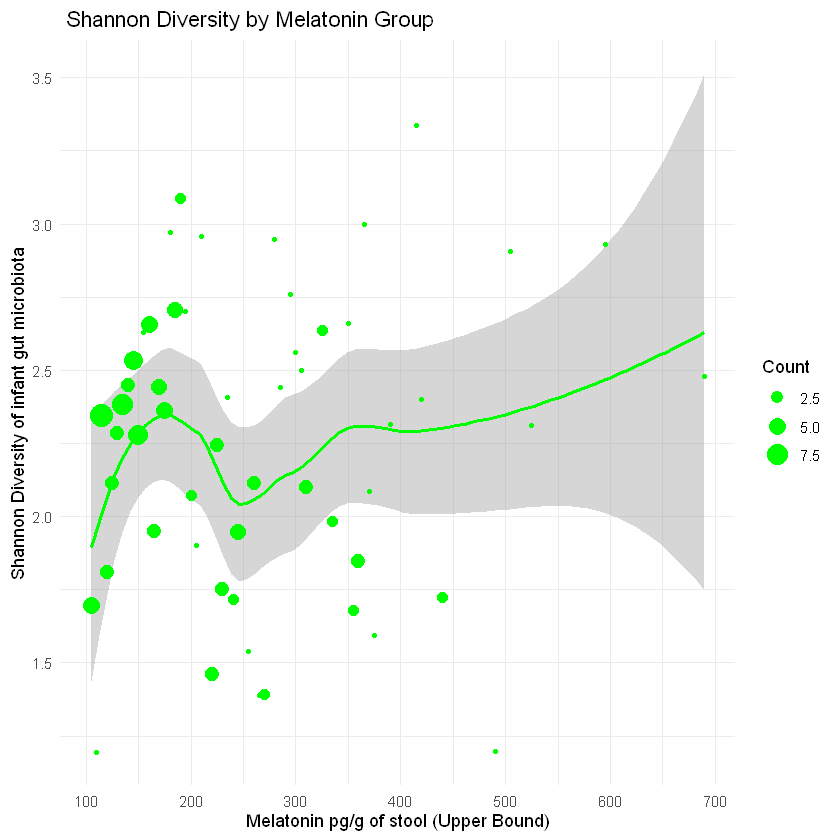

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."


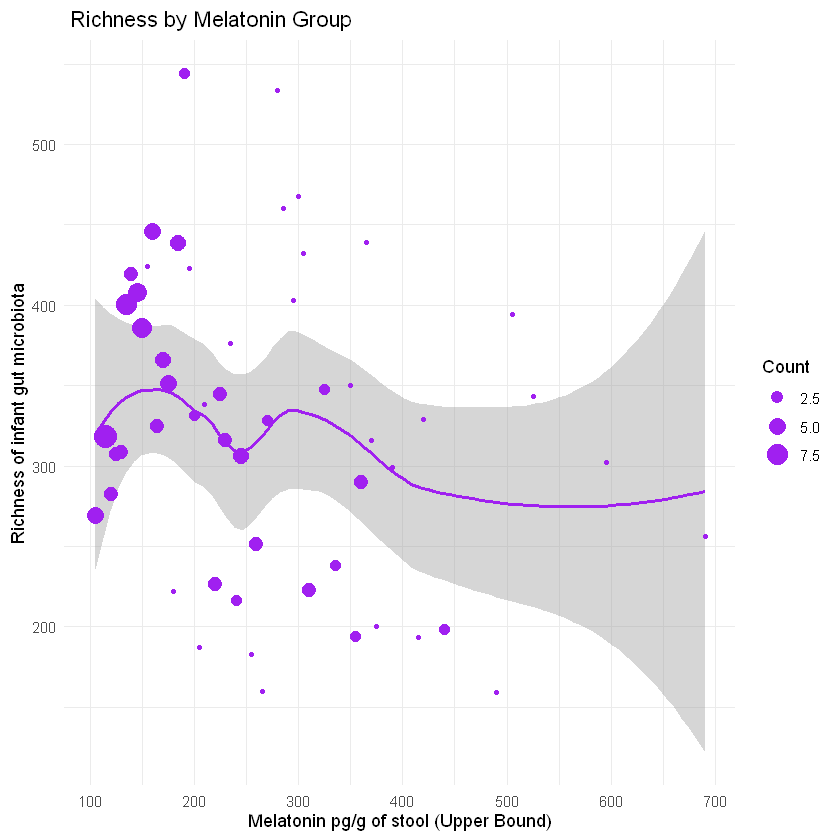

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."


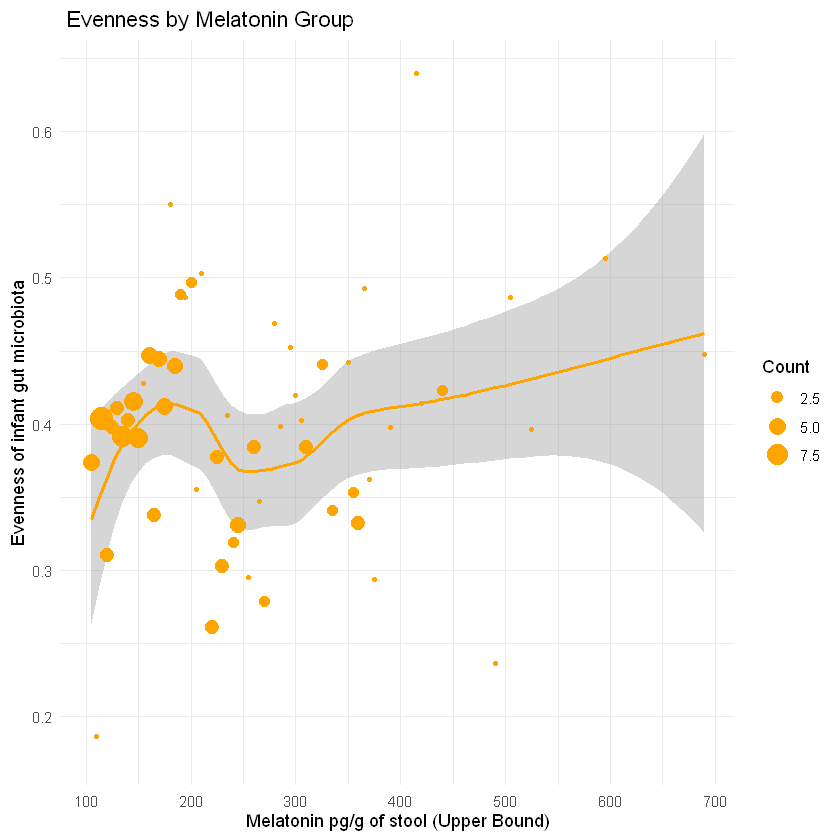

All plots have been saved in plots/6 months/ 


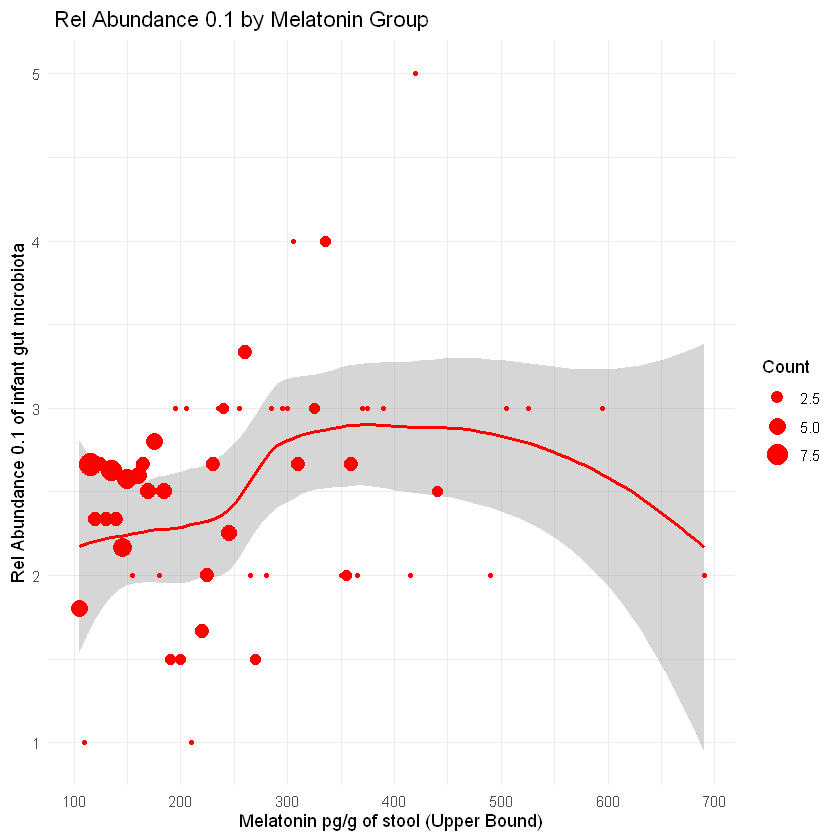

In [15]:
# Load necessary libraries
library(ggplot2)
library(dplyr)

# Convert Melatonin_Group to numeric for plotting
filtered_data <- filtered_data %>%
  mutate(Melatonin_Group = as.numeric(as.character(Melatonin_Group)))

# Step 1: Define a function to create and save the plot
plot_smooth_curve <- function(response_var, response_name, color, save_filename) {
  plot <- ggplot(filtered_data, aes(x = Melatonin_Group, y = get(response_var))) +
    geom_smooth(method = "loess", color = color, size = 1) +  # Smooth curve with loess
    geom_point(aes(size = Count), color = color) +  # Point size based on count
    ggtitle(paste("", response_name, "by Melatonin Group")) +
    xlab("Melatonin pg/g of stool (Upper Bound)") +
    ylab(paste(response_name, "of infant gut microbiota")) +
    scale_x_continuous(breaks = seq(0, 
                                   1000, 
                                    by = 100)) +  # Increment x-axis by 50

    theme_minimal()

    print(plot)
  
  # Save the plot
  ggsave(filename = save_filename, plot = plot, width = 7, height = 5)
}

# Step 2: Save the plots as images
plot_dir <- paste0("plots/", Age, "/")
if (!dir.exists(plot_dir)) {
  dir.create(plot_dir, recursive = TRUE)  # Ensure all subdirectories are created
}


# Step 3: Apply the function for all the parameters
plot_smooth_curve("Abundance_all_mean", "Abundance_all", "blue", paste0(plot_dir, "Abundance_all_mean_plot.jpg"))
plot_smooth_curve("Shannon_Diversity_mean", "Shannon Diversity", "green", paste0(plot_dir, "Shannon_Diversity_mean_plot.svg"))
plot_smooth_curve("Richness_mean", "Richness", "purple", paste0(plot_dir, "Richness_mean_plot.svg"))
plot_smooth_curve("Evenness_mean", "Evenness", "orange", paste0(plot_dir, "Evenness_mean_plot.jpg"))
plot_smooth_curve("Rel_Abun_0.1_mean", "Rel Abundance 0.1", "red", paste0(plot_dir, "Rel_Abun_0.1_mean_plot.jpg"))

# Optional: Print confirmation message
cat("All plots have been saved in", plot_dir, "\n")


In [16]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(broom)  # for tidy model results

# Step 1: Ensure Melatonin_Group is numeric
filtered_data <- filtered_data %>%
  mutate(Melatonin_Group = as.numeric(Melatonin_Group))

# Step 2: Define a function to perform linear regression, calculate correlations, and plot
perform_analysis <- function(response_var, response_name) {
  # Linear regression
  #lm_model <- lm(as.formula(paste(response_var, "~ Melatonin_Group")) + filtered_data$Clock_stool_numeric_mean, data = filtered_data)
  lm_model <- lm(as.formula(paste(response_var, "~ Melatonin_Group")), data = filtered_data)

  lm_p_value <- summary(lm_model)$coefficients[2, 4]
  
  # Spearman correlation
  corr_test <- cor.test(filtered_data$Melatonin_Group, filtered_data[[response_var]], method = "spearman")
  corr_value <- corr_test$estimate
  corr_p_value <- corr_test$p.value
  
  # Plot
  plot <- ggplot(filtered_data, aes(x = Melatonin_Group, y = get(response_var))) +
    geom_point() +
    geom_smooth(method = "lm", color = "blue", se = FALSE) +
    ggtitle(paste("Regression between Melatonin and", response_name)) +
    xlab("Melatonin pg/g of stool") +
    ylab(paste0(response_name, "of infant gut microbiota")) +
    theme_minimal() +
    annotate("text", x = max(filtered_data$Melatonin_Group, na.rm = TRUE), 
             y = max(filtered_data[[response_var]], na.rm = TRUE), 
             label = paste(" p-value:", round(lm_p_value, 5), "\n r:", round(corr_value, 5)), 
             hjust = 1, vjust = 1)
  
  return(list(
    plot = plot, 
    lm_p_value = lm_p_value, 
    corr_value = corr_value, 
    corr_p_value = corr_p_value
  ))
}

# Step 3: Apply the function to variables
results_list <- list(
  Abundance_all = perform_analysis("Abundance_all_mean", "Abundance_all"),
  Rel_Abun_0.1 = perform_analysis("Rel_Abun_0.1_mean", "Rel_Abun_0.1"),
  Richness = perform_analysis("Richness_mean", "Richness"),
  Shannon_Diversity = perform_analysis("Shannon_Diversity_mean", "Shannon Diversity"),
  Evenness = perform_analysis("Evenness_mean", "Evenness")
)

# Step 4: Create a data frame to save p-values and correlations
p_values_df <- data.frame(
  Measure = c("Abundance_all", "Rel_Abun_0.1", "Richness", "Shannon_Diversity", "Evenness"),
  Linear_P_value = sapply(results_list, function(x) x$lm_p_value),
  Spearman_Corr = sapply(results_list, function(x) x$corr_value),
  Spearman_P_value = sapply(results_list, function(x) x$corr_p_value)
)

# Step 6: Save the plots as images
plot_dir <- paste0("Version - 2  Experiments - 2025/plots/", Age, "/with_clock_stool_control_var/")
if (!dir.exists(plot_dir)) {
  dir.create(plot_dir, recursive = TRUE)  # Ensure all subdirectories are created
}
                         
# Step 5: Save the p-values and correlations to a CSV file
write.csv(p_values_df, file = paste0(plot_dir, Age, "_p_values_and_correlations_control_var.csv"), row.names = FALSE)



# Save each plot
ggsave(filename = paste0(plot_dir, "2Abundance_all_plot.svg"), plot = results_list$Abundance_all$plot, width = 7, height = 5)
ggsave(filename = paste0(plot_dir, "2Rel_Abun_0.1_plot.svg"), plot = results_list$Rel_Abun_0.1$plot, width = 7, height = 5)
ggsave(filename = paste0(plot_dir, "2Richness_plot.svg"), plot = results_list$Richness$plot, width = 7, height = 5)
ggsave(filename = paste0(plot_dir, "2Shannon_Diversity_plot.svg"), plot = results_list$Shannon_Diversity$plot, width = 7, height = 5)
ggsave(filename = paste0(plot_dir, "2Evenness_plot.svg"), plot = results_list$Evenness$plot, width = 7, height = 5)



Warning message:
"package 'broom' was built under R version 4.4.2"
Warning message in cor.test.default(filtered_data$Melatonin_Group, filtered_data[[response_var]], :
"Cannot compute exact p-value with ties"
Warning message in cor.test.default(filtered_data$Melatonin_Group, filtered_data[[response_var]], :
"Cannot compute exact p-value with ties"
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 1 row containing non-finite outside the scale range (`stat_smooth()`)."
Warning message

In [24]:
# Load required libraries
library(tidyverse)
library(Maaslin2)

# Load the data
data <-  filtered_data

# Add row_id as a unique identifier for rows
data$row_id <- as.character(seq_len(nrow(data)))

# Define feature and metadata columns
feature_columns <- c( "Shannon_Diversity_mean", 
                     "Richness_mean", "Evenness_mean", 
                     "Rel_Abun_0.1_mean")
metadata_columns <- setdiff(names(data), feature_columns)

# Create feature table with row_id as row names
feature_table <- data %>%
  select(all_of(feature_columns), row_id) %>%
  column_to_rownames(var = "row_id")

# Create metadata table with row_id as row names
metadata_table <- data %>%
  select(all_of(metadata_columns), row_id) %>%
  column_to_rownames(var = "row_id")

# Verify the row names match
if (!all(rownames(feature_table) == rownames(metadata_table))) {
  stop("Row names of feature_table and metadata_table do not match!")
}

# Run Maaslin2
results <- Maaslin2(
  input_data = feature_table,
  input_metadata = metadata_table,
  output = "maaslin2_output",
  fixed_effects = c("Melatonin_pg_g_Stool_scaled_mean", "Clock_stool_numeric_mean"),
  random_effects = NULL,
  normalization = "NONE",
  transform = "NONE"
)

# Print summary of the results
print("Maaslin2 analysis complete!")


[1] "Warning: Deleting existing log file: maaslin2_output/maaslin2.log"
2025-01-22 20:15:22.269939 INFO::Writing function arguments to log file
2025-01-22 20:15:22.28598 INFO::Verifying options selected are valid
2025-01-22 20:15:22.287167 INFO::Determining format of input files
2025-01-22 20:15:22.288357 INFO::Input format is data samples as rows and metadata samples as rows
2025-01-22 20:15:22.29176 INFO::Formula for fixed effects: expr ~  Melatonin_pg_g_Stool_scaled_mean + Clock_stool_numeric_mean
2025-01-22 20:15:22.293924 INFO::Filter data based on min abundance and min prevalence
2025-01-22 20:15:22.296486 INFO::Total samples in data: 56
2025-01-22 20:15:22.298312 INFO::Min samples required with min abundance for a feature not to be filtered: 5.600000
2025-01-22 20:15:22.300276 INFO::Total filtered features: 0
2025-01-22 20:15:22.301882 INFO::Filtered feature names from abundance and prevalence filtering:
2025-01-22 20:15:22.30423 INFO::Total filtered features with variance filte

In [28]:
metadata_table

Melatonin_Group Abundance_all_mean Melatonin_pg_g_Stool_scaled_mean
1  105             117385.4           -0.60242517                     
2  110             134572.0           -0.57191097                     
3  115             141235.0           -0.52890198                     
4  120             179635.0           -0.48960488                     
5  125             140409.0           -0.46606088                     
6  130             120572.0           -0.41444520                     
7  135             154650.6           -0.37713151                     
8  140             216184.7           -0.34790036                     
9  145             138247.3           -0.30578059                     
10 150             149531.0           -0.27648171                     
11 155             278289.0           -0.23497728                     
12 160             152010.4           -0.20330302                     
13 165             200209.7           -0.16060077                     
14 170             126439.0           -0.13123196                     
15 175             133442.2           -0.08365448                     
16 180              61206.0           -0.06104050                     
17 185             180860.5           -0.01372000                     
18 190              71344.5            0.01928320                     
19 195              70926.0            0.06223509                     
20 200             116147.0            0.09619278                     
21 205              66292.0            0.14593620                     
22 210             117828.0            0.18426250                     
23 220             176077.0            0.23352868                     
24 225             117426.0            0.27092497                     
25 230             150091.7            0.32574675                     
26 235              80542.0            0.36510095                     
27 240             107247.0            0.39384568                     
28 245             168083.0            0.42952878                     
29 255             135404.0            0.50680547                     
30 260             141217.3            0.54106908                     
31 265             113639.0            0.56862682                     
32 270             199069.5            0.60746707                     
33 280              78020.0            0.67134424                     
34 285             165511.0            0.71928882                     
35 295              80997.0            0.78793842                     
36 300             202929.0            0.82788000                     
37 305             136077.0            0.86951029                     
38 310             139684.0            0.90981898                     
39 325              57299.5            1.01642777                     
40 335             106639.5            1.08878518                     
41 350              76028.0            1.18434395                     
42 355             100205.0            1.24737676                     
43 360             194907.7            1.26620951                     
44 365             293674.0            1.29543148                     
45 370             143241.0            1.35739967                     
46 375             118023.0            1.39198145                     
47 390              71796.0            1.50292213                     
48 415              81200.0            1.68838617                     
49 420              48317.0            1.69433336                     
50 440              92350.0            1.84885002                     
51 490             125718.0            2.22532147                     
52 505              58069.0            2.32488174                     
53 525             101335.0            2.48582283                     
54 595              89356.0            3.01233219                     
55 690              30078.0            3.70125109                     
56  NA             293463.0

In [25]:
# Step 6: Save the plots as images
plot_dir <- paste0("Version - 2  Experiments - 2025/plots/", Age, "/results_from_Maaslin2/")
if (!dir.exists(plot_dir)) {
  dir.create(plot_dir, recursive = TRUE)  # Ensure all subdirectories are created
}

# Save Maaslin2 results to a CSV file
write.csv(results$results, file = paste0(plot_dir, Age, "maaslin2_results_all.csv"), row.names = FALSE)


In [20]:
# Load required libraries
library(tidyverse)
library(Maaslin2)

# Load the data
data <- filtered_data

# Add row_id as a unique identifier for rows
data$row_id <- as.character(seq_len(nrow(data)))

# Define Shannon Diversity as the only feature
feature_table <- data %>%
  select(Rel_Abun_0.1_mean, row_id) %>% # Shannon_Diversity_mean, Richness_mean, Evenness_mean, Rel_Abun_0.1_mean, 
  column_to_rownames(var = "row_id")

# Define metadata including the predictor and covariate
metadata_table <- data %>%
  select(Melatonin_pg_g_Stool_mean, Clock_stool_numeric_mean, row_id) %>%
  column_to_rownames(var = "row_id")

# Verify that row names match
if (!all(rownames(feature_table) == rownames(metadata_table))) {
  stop("Row names of feature_table and metadata_table do not match!")
}

# Run Maaslin2 with Shannon Diversity as the dependent variable
results <- Maaslin2(
  input_data = feature_table,
  input_metadata = metadata_table,
  output = paste0("results/", Age,"/"),,
  fixed_effects = c("Melatonin_pg_g_Stool_mean", "Clock_stool_numeric_mean"),
  random_effects = NULL,
  normalization = "NONE",
  transform = "NONE"
)

# Print summary of the results
print("Maaslin2 analysis complete!")


[1] "Creating output folder"


Warning message in dir.create(output):
"cannot create dir 'results\6 months', reason 'No such file or directory'"


[1] "Creating output feature tables folder"


Warning message in dir.create(features_folder):
"cannot create dir 'results\6 months\\features', reason 'No such file or directory'"


[1] "Creating output fits folder"


Warning message in dir.create(fits_folder):
"cannot create dir 'results\6 months\\fits', reason 'No such file or directory'"


[1] "Creating output figures folder"


Warning message in dir.create(figures_folder):
"cannot create dir 'results\6 months\\figures', reason 'No such file or directory'"


2025-01-22 20:12:07.07631 INFO::Writing function arguments to log file


Warning message in file(file, ifelse(append, "a", "w")):
"cannot open file 'results/6 months//maaslin2.log': No such file or directory"


ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


In [ ]:
results


# Step 6: Save the plots as images
plot_dir <- paste0("Version - 2  Experiments - 2025/plots/", Age, "/results_from_Maaslin2/")
if (!dir.exists(plot_dir)) {
  dir.create(plot_dir, recursive = TRUE)  # Ensure all subdirectories are created
}

# Save Maaslin2 results to a CSV file
write.csv(results$results, file = paste0(plot_dir, Age, "maaslin2_results_Rel_Abun_0.1_mean.csv"), row.names = FALSE)
 

In [21]:
# Extract relevant columns from the Maaslin2 results
results_df <- results$results %>%
  dplyr::select(feature, coef, pval) %>%
  mutate(
    qval = p.adjust(pval, method = "fdr")  # Apply FDR correction to p-values
  )

# View the results dataframe
print(results_df)


                           feature          coef      pval      qval
1               Abundance_all_mean -4.474988e+03 0.5674210 0.9729103
2           Shannon_Diversity_mean -2.577632e-02 0.7187858 0.9729103
3                    Richness_mean -2.034292e+00 0.8730861 0.9729103
4                    Evenness_mean -3.927549e-04 0.9729103 0.9729103
5                Rel_Abun_0.1_mean  5.198082e-02 0.5896752 0.9729103
6 Melatonin_pg_g_Stool_scaled_mean -1.266970e-01 0.3683354 0.9729103


In [22]:
# Adjust p-values for multiple comparisons using FDR (Benjamini-Hochberg procedure)
results_df$qval_corrected <- p.adjust(results_df$pval, method = "fdr")

# View the corrected q-values
print(results_df)


                           feature          coef      pval      qval
1               Abundance_all_mean -4.474988e+03 0.5674210 0.9729103
2           Shannon_Diversity_mean -2.577632e-02 0.7187858 0.9729103
3                    Richness_mean -2.034292e+00 0.8730861 0.9729103
4                    Evenness_mean -3.927549e-04 0.9729103 0.9729103
5                Rel_Abun_0.1_mean  5.198082e-02 0.5896752 0.9729103
6 Melatonin_pg_g_Stool_scaled_mean -1.266970e-01 0.3683354 0.9729103
  qval_corrected
1      0.9729103
2      0.9729103
3      0.9729103
4      0.9729103
5      0.9729103
6      0.9729103


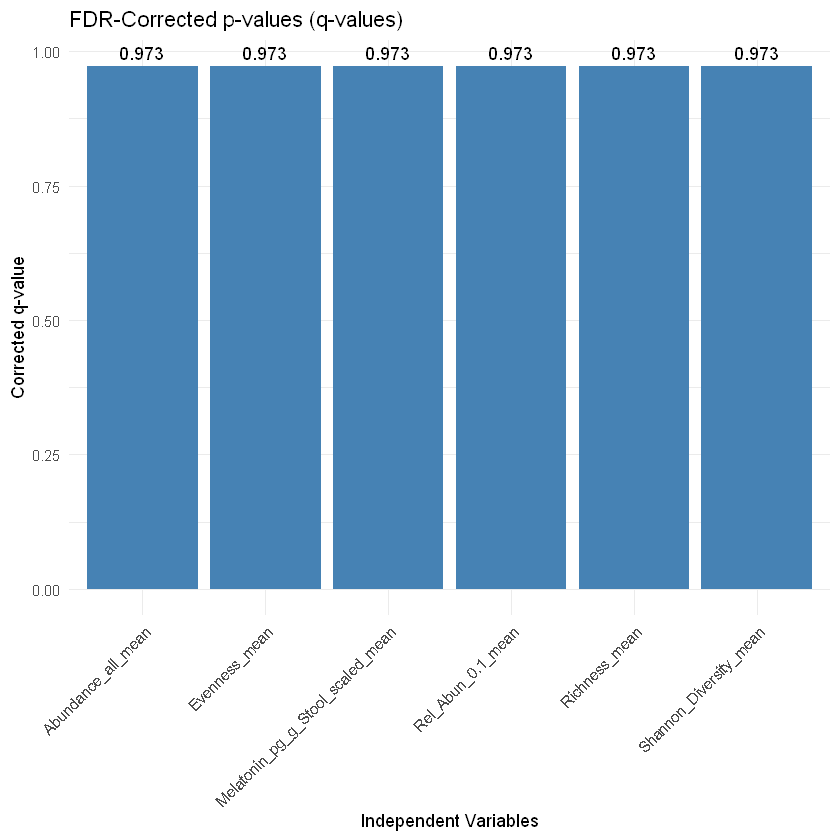

In [23]:
# Plot the FDR-corrected q-values
ggplot(results_df, aes(x = feature, y = qval_corrected)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_text(aes(label = round(qval_corrected, 3)), vjust = -0.5) +
  labs(title = "FDR-Corrected p-values (q-values)",
       x = "Independent Variables",
       y = "Corrected q-value") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [ ]:
# Load necessary library
library(ggplot2)

# Calculate the linear regression model
model <- lm(Richness_mean ~ Melatonin_pg_g_Stool_scaled_mean, data = filtered_data)

# Extract regression statistics
fdr <- summary(model)$coefficients[2, 4]  # p-value from the model
coefficient <- summary(model)$coefficients[2, 1]
n <- nrow(filtered_data)

# Generate the plot
ggplot(filtered_data, aes(x = Melatonin_pg_g_Stool_scaled_mean, y = Shannon_Diversity_mean)) +
  geom_point(color = "darkgreen", alpha = 0.6, size = 3) +  # Scatter points
  geom_smooth(method = "lm", color = "blue", fill = "lightblue", se = TRUE) +  # Regression line with CI
  theme_minimal() +  # Clean theme
  labs(
    x = "Melatonin_pg_g_Stool_scaled_mean",
    y = "Shannon_Diversity_mean",
    title = "Linear Regression of Shannon Diversity vs Melatonin"
  ) +
  annotate(
    "text",
    x = min(filtered_data$Melatonin_pg_g_Stool_scaled_mean),
    y = max(filtered_data$Shannon_Diversity_mean),
    label = paste0("FDR: ", signif(fdr, 3), "\nCoefficient: ", signif(coefficient, 3)),
    hjust = 0,
    size = 5
  )
